# Earthquake

## Setup Enviroments & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
import re

In [26]:
pd.set_option("display.max_rows",10000)

In [2]:
# df_ = pd.read_csv("/content/drive/MyDrive/MiuulProje/turkey_earthquakes1915-2023_may.csv", encoding="unicode-escape", sep=",",on_bad_lines="skip")
# df2_ = pd.read_csv("/content/drive/MyDrive/MiuulProje/veri2.csv", encoding="unicode-escape", sep=";",on_bad_lines="skip")

In [3]:
# df_["Yer"] = df2_["Yer"].copy()

In [4]:
df_ = pd.read_csv("/content/drive/MyDrive/MiuulProje/dataset.csv", encoding="unicode-escape", sep=",",on_bad_lines="skip",index_col="Unnamed: 0")

In [5]:
df = df_.copy()

## EDA & Preprocess

In [6]:
df.head()

,No,Deprem Kodu,Olus tarihi,Olus zamani,Enlem,Boylam,Derinlik,xM,MD,ML,Mw,Ms,Mb,Tip,Yer
0,1,20230430130127,2023.04.30,13:01:27.69,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,0.0,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,20230430040253,2023.04.30,04:02:53.49,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,0.0,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,20230430025122,2023.04.30,02:51:22.15,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,0.0,Ke,AKDENIZ
3,4,20230429194832,2023.04.29,19:48:32.87,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,0.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,20230429175829,2023.04.29,17:58:29.20,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,0.0,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19908 entries, 0 to 19907
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           19908 non-null  int64  
 1   Deprem Kodu  19908 non-null  int64  
 2   Olus tarihi  19908 non-null  object 
 3   Olus zamani  19908 non-null  object 
 4   Enlem        19908 non-null  float64
 5   Boylam       19908 non-null  float64
 6   Derinlik     19908 non-null  float64
 7   xM           19908 non-null  float64
 8   MD           19908 non-null  float64
 9   ML           19908 non-null  float64
 10  Mw           6927 non-null   float64
 11  Ms           19908 non-null  float64
 12  Mb           19908 non-null  float64
 13  Tip          19908 non-null  object 
 14  Yer          19908 non-null  object 
dtypes: float64(9), int64(2), object(4)
memory usage: 2.4+ MB


Her yılda kaç gün var ona bakalım. Az olanları çıkartalım. Zamansal olarak ekisk veri bizi aşırı zorlar. Ayrıca, sahte trendler oluşmasına engel olmamız lazım.

In [8]:
df.columns

Index(['No', 'Deprem Kodu', 'Olus tarihi', 'Olus zamani', 'Enlem', 'Boylam',
       'Derinlik', 'xM', 'MD', 'ML', 'Mw', 'Ms', 'Mb', 'Tip', 'Yer'],
      dtype='object')

In [9]:
# Değişken isimlerini küçültüyorum
df.columns = [col.lower() for col in df.columns]

In [10]:
df.head()

,no,deprem kodu,olus tarihi,olus zamani,enlem,boylam,derinlik,xm,md,ml,mw,ms,mb,tip,yer
0,1,20230430130127,2023.04.30,13:01:27.69,38.3392,37.7633,8.7,4.3,0.0,4.3,4.3,0.0,0.0,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km]
1,2,20230430040253,2023.04.30,04:02:53.49,40.8077,31.0708,3.7,3.5,0.0,3.5,3.4,0.0,0.0,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km]
2,3,20230430025122,2023.04.30,02:51:22.15,35.6422,34.0252,22.4,3.5,0.0,3.5,3.5,0.0,0.0,Ke,AKDENIZ
3,4,20230429194832,2023.04.29,19:48:32.87,37.8623,36.2185,5.0,4.0,0.0,3.9,4.0,0.0,0.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km]
4,5,20230429175829,2023.04.29,17:58:29.20,38.0220,36.4457,5.0,3.7,0.0,3.7,3.4,0.0,0.0,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....


In [11]:
df.drop(["md","ml","mw","ms","mb"],axis=1,inplace=True)

In [12]:
df["olus tarihi"] = df["olus tarihi"].astype(str)

In [13]:
df["olus zamani"] = df["olus zamani"].astype(str)

In [14]:
# tip değişkeni 2 sınıf ve SM sınıfından sadece 2 gözlem var. O yüzden dropluyorum bu kolonu.
df["depremin_olus_zamani"] = df["olus tarihi"] + " " + df["olus zamani"]
df.drop(["olus tarihi", "olus zamani", "tip"], axis = 1, inplace = True)

In [15]:
df.head()

,no,deprem kodu,enlem,boylam,derinlik,xm,yer,depremin_olus_zamani
0,1,20230430130127,38.3392,37.7633,8.7,4.3,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023.04.30 13:01:27.69
1,2,20230430040253,40.8077,31.0708,3.7,3.5,PASAKONAGI- (DUZCE) [South West 0.9 km],2023.04.30 04:02:53.49
2,3,20230430025122,35.6422,34.0252,22.4,3.5,AKDENIZ,2023.04.30 02:51:22.15
3,4,20230429194832,37.8623,36.2185,5.0,4.0,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023.04.29 19:48:32.87
4,5,20230429175829,38.0220,36.4457,5.0,3.7,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023.04.29 17:58:29.20


In [16]:
df["depremin_olus_zamani"] = pd.to_datetime(df["depremin_olus_zamani"])

In [21]:
df.describe([0.1,0.2,0.5,0.75,0.9,0.95,0.99])

,no,deprem kodu,enlem,boylam,derinlik,xm
count,19908.000000,1.990800e+04,19908.000000,19908.000000,19908.000000,19908.000000
mean,9954.500000,1.998843e+13,38.048908,32.445884,14.783353,3.981932
std,5747.088915,2.032333e+11,1.599778,5.836924,20.689789,0.531742
min,1.000000,1.915021e+13,35.000000,26.000000,0.000000,3.500000
10%,1991.700000,1.971092e+13,35.800000,26.722940,2.500000,3.500000
20%,3982.400000,1.982063e+13,36.475320,27.220000,5.000000,3.600000
50%,9954.500000,2.003112e+13,38.110000,29.750000,8.500000,3.800000
75%,14931.250000,2.015022e+13,39.122775,37.260000,14.000000,4.200000
90%,17917.300000,2.021073e+13,40.350000,42.370000,33.000000,4.700000
95%,18912.650000,2.023021e+13,40.750000,43.574695,57.165000,5.100000


**Gerçekleşen depremlerin sadece %5'i 5.0'dan büyük.**

In [24]:
df.shape, df.no.nunique(), df["deprem kodu"].nunique()

((19908, 8), 19908, 19907)

In [25]:
df.drop_duplicates(subset=["deprem kodu"],inplace = True)
df.shape

(19907, 8)

In [29]:
df["depremin_olus_zamani"].min(), df["depremin_olus_zamani"].max()

(Timestamp('1915-02-14 08:20:00.600000'),
 Timestamp('2023-04-30 13:01:27.690000'))

In [32]:
# Türkçe karakterleri İngilizce karakterlere dönüştüren bir çeviri sözlüğü oluşturalım
turkce_ingilizce_ceviri = {
    'ç': 'c',
    'ğ': 'g',
    'ı': 'i',
    'ö': 'o',
    'ş': 's',
    'ü': 'u',
    'Ç': 'C',
    'Ğ': 'G',
    'İ': 'I',
    'Ö': 'O',
    'Ş': 'S',
    'Ü': 'U'
}


df["yer"] = df["yer"].apply(lambda yer: yer.translate(str.maketrans(turkce_ingilizce_ceviri)))

In [34]:
# Şehir isimlerini çekmek için düzenli ifade kullanalım

def extract_cities(dataframe,column):
  sadece_sehirler = []
  for yer in dataframe[column]:
      eslesme = re.search(r'\((.*?)\)', yer)  # Parantez içindekileri kontrol et
      if eslesme:
          sadece_sehirler.append(eslesme.group(1))  # Parantez içindeki değeri ekle
      else:
          sadece_sehirler.append(yer)  # Parantez içinde değer yoksa doğrudan ekle
  return sadece_sehirler

df["temizlenmis_yer"] = extract_cities(df,"yer")

In [38]:
# Köşeli parantezleri atıyoruz. Böylelikle o şehir/alandaki depremlere odaklanmış oluyoruz.
df["temizlenmis_yer"] = df["temizlenmis_yer"].apply(lambda yer: re.sub(r'\[.*?\]', '', yer))

In [39]:
df.groupby("temizlenmis_yer").agg({"temizlenmis_yer":"count"})

,temizlenmis_yer
temizlenmis_yer,
#NAME?,4
ABAS-EMET KUTAHYA,3
ABIDE-GEDIZ KUTAHYA,2
ADANA,201
ADANA,2
ADIYAMAN,219
AFYONKARAHISAR,320
AFYONKARAHiSAR,1
AGAC-DUMLUPINAR KUTAHYA,1


In [44]:
# Yerin neresi olduğu belli olmadığı için çıkartıyorum.
df = df[~(df["temizlenmis_yer"] == "#NAME?")]

In [45]:
df.isnull().sum()

no                      0
deprem kodu             0
enlem                   0
boylam                  0
derinlik                0
xm                      0
yer                     0
depremin_olus_zamani    0
temizlenmis_yer         0
dtype: int64

In [77]:
df.columns

Index(['no', 'deprem kodu', 'enlem', 'boylam', 'derinlik', 'xm', 'yer',
       'depremin_olus_zamani', 'temizlenmis_yer'],
      dtype='object')

In [90]:
df.groupby("temizlenmis_yer").agg({"xm":["count","mean","median","std"]}).sort_values(by=("xm","mean"),ascending= False)

xm                           
                                    count      mean median       std
temizlenmis_yer                                                     
ERZINCAN                                1  6.000000   6.00       NaN
KUCUKKOY-DOMANIC KUTAHYA                1  5.800000   5.80       NaN
KONUS-EMET KUTAHYA                      1  5.600000   5.60       NaN
MURATLI-DOMANIC KUTAHYA                 1  5.600000   5.60       NaN
YENIKOY-SIMAV KUTAHYA                   1  5.600000   5.60       NaN
CARSAMBA-DOMANIC KUTAHYA                1  5.500000   5.50       NaN
ARDAHAN                                 1  5.500000   5.50       NaN
AKPINAR-CAVDARHISAR KUTAHYA             1  5.500000   5.50       NaN
KARAKOY-DOMANIC KUTAHYA                 1  5.400000   5.40       NaN
GUMUSGOLCUK-TAVSANLI KUTAHYA            1  5.300000   5.30       NaN
BASOREN- KUTAHYA                        1  5.300000   5.30       NaN
KOCAELI                                 1  5.200000   5.20       NaN
CERTE-EMET KUTAHYA                      1  5.100000   5.10       NaN
KIZIK-CAVDARHISAR KUTAHYA               3  5.066667   4.40  1.700980
IKIBASLI-EMET KUTAHYA                   1  5.000000   5.00       NaN
BAHATLAR-EMET KUTAHYA                   4  4.950000   4.90  0.331662
SAMRALAR-GEDIZ KUTAHYA                  2  4.900000   4.90  0.282843
SAKLAR-HISARCIK KUTAHYA                 1  4.900000   4.90       NaN
KIRGIL-EMET KUTAHYA                     1  4.900000   4.90       NaN
DOMANIC KUTAHYA                         1  4.900000   4.90       NaN
ORHANLAR-PAZARLAR KUTAHYA               1  4.900000   4.90       NaN
ALLIOREN-DUMLUPINAR KUTAHYA             3  4.833333   4.70  0.321455
CAKILLI-TAVSANLI KUTAHYA                1  4.800000   4.80       NaN
SUMAKLI-GEDIZ KUTAHYA                   1  4.800000   4.80       NaN
AKCAKOY-ALTINTAS KUTAHYA                1  4.800000   4.80       NaN
SINOP                                   1  4.800000   4.80       NaN
EYIDEMIR-DUMLUPINAR KUTAHYA             5  4.700000   4.90  0.524404
ILICASU-GEDIZ KUTAHYA                   1  4.700000   4.70       NaN
ORTACA-DOMANIC KUTAHYA                  2  4.700000   4.70  1.131371
DOGANCILAR-CAVDARHISAR KUTAHYA          1  4.700000   4.70       NaN
OMERFAKI-EMET KUTAHYA                   1  4.700000   4.70       NaN
TOKAT                                   1  4.700000   4.70       NaN
SEYHCAKIR-HISARCIK KUTAHYA              1  4.700000   4.70       NaN
TOKUL-ASLANAPA KUTAHYA                 11  4.690909   4.90  0.902723
ALINCIK-ALTINTAS KUTAHYA                5  4.660000   4.60  0.691375
AZERBAYCAN                             65  4.629231   4.70  0.580604
TURKIYE-ERMENISTAN SINIR BOLGESI        5  4.620000   4.70  0.277489
GENISLER-ALTINTAS KUTAHYA               1  4.600000   4.60       NaN
DUMLUPINAR KUTAHYA                      2  4.600000   4.60  0.000000
ARMENIA                                 1  4.600000   4.60       NaN
EFENDIKOPRUSU-CAVDARHISAR KUTAHYA       2  4.600000   4.60  0.424264
SARAYCIK-ALTINTAS KUTAHYA              12  4.575000   4.85  0.852936
PAZARLAR KUTAHYA                        2  4.550000   4.55  0.353553
EMET KUTAHYA                            8  4.525000   4.45  0.755456
YUMRUTAS-GEDIZ KUTAHYA                  1  4.500000   4.50       NaN
CUBUKICI- KUTAHYA                       1  4.500000   4.50       NaN
KUS GOLU                                1  4.500000   4.50       NaN
HACIBABA-GEDIZ KUTAHYA                  2  4.500000   4.50  0.000000
YAGCILAR-ASLANAPA KUTAHYA               1  4.500000   4.50       NaN
CALCAAGIL-EMET KUTAHYA                  1  4.500000   4.50       NaN
CAVDARHISAR KUTAHYA                     1  4.500000   4.50       NaN
UZUMLU-GEDIZ KUTAHYA                    1  4.500000   4.50       NaN
AKKAYA-GEDIZ KUTAHYA                    4  4.475000   4.60  0.602080
GONCEK-EMET KUTAHYA                     2  4.450000   4.45  0.070711
SAZ-GEDIZ KUTAHYA                       5  4.420000   4.40  0.496991
KÃ¯Â¿Â½TAHYA KUTAHYA                 

## Kaggle Test Veri seti oluşturma

In [60]:
zurna_durum = df["temizlenmis_yer"].value_counts().index

In [63]:
len(zurna_durum)

368

In [61]:
kaggle_test_df = pd.DataFrame(columns=["temizlenmis_yer","tarih"])
for yer in zurna_durum:
  for tarih in pd.date_range(start='2023-09-10', end='2023-09-15'):
    new_line={"temizlenmis_yer":yer, "tarih": tarih}
    kaggle_test_df.loc[len(kaggle_test_df)] = new_line

In [62]:
kaggle_test_df.shape

(2208, 2)

Bu çıktının sebebi: 368 * 6 (Gün)

In [64]:
kaggle_test_df["xM"] = np.NaN

In [65]:
kaggle_test_df.head()

,temizlenmis_yer,tarih,xM
0,AKDENIZ,2023-09-10,NaN
1,AKDENIZ,2023-09-11,NaN
2,AKDENIZ,2023-09-12,NaN
3,AKDENIZ,2023-09-13,NaN
4,AKDENIZ,2023-09-14,NaN


In [72]:
kaggle_test_df.sort_values(by = "tarih",inplace = True)

In [74]:
kaggle_test_df = kaggle_test_df.reset_index(drop=True)

In [75]:
kaggle_test_df.to_csv("kaggle_test.csv")

In [48]:
for tarih in pd.date_range(start='2023-09-10', end='2023-09-15'):
  print(tarih)

2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00


In [47]:
pd.date_range(start='2023-09-10', end='2023-09-15')

DatetimeIndex(['2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13',
               '2023-09-14', '2023-09-15'],
              dtype='datetime64[ns]', freq='D')

## Feature Engineering

In [ ]:
df["ay"] = df["depremin_olus_zamani"].dt.month
df["yıl"] = df["depremin_olus_zamani"].dt.year
df["ay_gun"] = df["depremin_olus_zamani"].dt.day
df["hafta_gun"] = df["depremin_olus_zamani"].dt.dayofweek
df["saat"] =  df["depremin_olus_zamani"].dt.hour
df["aksam"] = ((df['saat'] >= 18) & (df['saat'] <= 23)) | ((df['saat'] >= 0) & (df['saat'] <= 4))
df['yıl_gün'] = df["depremin_olus_zamani"].dt.dayofyear
df['yıl_hafta'] = df["depremin_olus_zamani"].dt.weekofyear

<ipython-input-97-65ab47123c9d>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['yıl_hafta'] = df["depremin_olus_zamani"].dt.weekofyear


In [ ]:
df["temizlenmis_yer"] = df["temizlenmis_yer"].apply(lambda yer: re.sub(r'\[.*?\]', '', yer))

In [ ]:
df.head()

,no,deprem_kodu,enlem,boylam,derinlik,xM,Tip,Yer,depremin_olus_zamani,ay,yıl,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,temizlenmis_yer
0,1,20230430130127,38.3392,37.7633,8.7,4.3,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,4,2023,30,6,13,False,120,17,MALATYA
1,2,20230430040253,40.8077,31.0708,3.7,3.5,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,4,2023,30,6,4,True,120,17,DUZCE
2,3,20230430025122,35.6422,34.0252,22.4,3.5,Ke,AKDENIZ,2023-04-30 02:51:22.150,4,2023,30,6,2,True,120,17,AKDENIZ
3,4,20230429194832,37.8623,36.2185,5.0,4.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,4,2023,29,5,19,True,119,17,ADANA
4,5,20230429175829,38.0220,36.4457,5.0,3.7,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,4,2023,29,5,17,False,119,17,KAHRAMANMARAS


In [ ]:
df.isnull().sum()

no                      0
deprem_kodu             0
enlem                   0
boylam                  0
derinlik                0
xM                      0
Tip                     0
Yer                     0
depremin_olus_zamani    0
ay                      0
yıl                     0
ay_gun                  0
hafta_gun               0
saat                    0
aksam                   0
yıl_gün                 0
yıl_hafta               0
temizlenmis_yer         0
dtype: int64

In [ ]:
# yıl yıl, ne kadar gözlem var bakalım:
df.groupby(["yıl","ay"])["deprem_kodu"].count()

yıl   ay
1915  2        2
      4        1
      5        1
      9        1
      12       1
1916  1        1
      4        1
      8        1
      10       1
      11       1
1917  1        1
      2        1
      3        1
      4        1
      6        2
      8        1
      12       1
1918  1        2
      3        3
      7        1
      8        2
      9        2
      11       4
1919  1        1
      4        1
      5        1
      6        2
      7        2
      8        3
      10       1
      11       1
1920  1        1
      4        1
      5        1
      7        3
      9        1
      11       1
1921  1        3
      4        1
      5        1
      7        1
      9        1
      10       1
1922  2        1
      4        1
      6        2
      8        5
      11       1
      12       1
1923  4        1
      5        2
      7        1
      8        1
      9        1
      10       1
      11       1
1924  1        1
      4        1
     

Çeyreklere göre ilerlemek mantıklı duruyor. Çeyreklere göre incleerim. Baktım boka batıyoruz, o zaman 1967 öncesini atarız.

In [ ]:
df["çeyreklik"] = df["depremin_olus_zamani"].dt.quarter
df.head()

,no,deprem_kodu,enlem,boylam,derinlik,xM,Tip,Yer,depremin_olus_zamani,ay,yıl,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,temizlenmis_yer,çeyreklik
0,1,20230430130127,38.3392,37.7633,8.7,4.3,Ke,KEPEZ-AKCADAG (MALATYA) [East 1.7 km],2023-04-30 13:01:27.690,4,2023,30,6,13,False,120,17,MALATYA,2
1,2,20230430040253,40.8077,31.0708,3.7,3.5,Ke,PASAKONAGI- (DUZCE) [South West 0.9 km],2023-04-30 04:02:53.490,4,2023,30,6,4,True,120,17,DUZCE,2
2,3,20230430025122,35.6422,34.0252,22.4,3.5,Ke,AKDENIZ,2023-04-30 02:51:22.150,4,2023,30,6,2,True,120,17,AKDENIZ,2
3,4,20230429194832,37.8623,36.2185,5.0,4.0,Ke,KARAKUYU-SAIMBEYLI (ADANA) [East 1.4 km],2023-04-29 19:48:32.870,4,2023,29,5,19,True,119,17,ADANA,2
4,5,20230429175829,38.0220,36.4457,5.0,3.7,Ke,YIRICEK-GOKSUN (KAHRAMANMARAS) [North West 2....,2023-04-29 17:58:29.200,4,2023,29,5,17,False,119,17,KAHRAMANMARAS,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19907 entries, 0 to 19907
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   no                    19907 non-null  int64         
 1   deprem_kodu           19907 non-null  int64         
 2   enlem                 19907 non-null  float64       
 3   boylam                19907 non-null  float64       
 4   derinlik              19907 non-null  float64       
 5   xM                    19907 non-null  float64       
 6   Tip                   19907 non-null  object        
 7   Yer                   19907 non-null  object        
 8   depremin_olus_zamani  19907 non-null  datetime64[ns]
 9   ay                    19907 non-null  int64         
 10  yıl                   19907 non-null  int64         
 11  ay_gun                19907 non-null  int64         
 12  hafta_gun             19907 non-null  int64         
 13  saat            

In [ ]:
df["aksam"] = df['aksam'].astype(int)

In [ ]:
df.describe([0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
no,19907.0,9.954008e+03,5.746813e+03,1.000000e+00,9.963000e+02,1.991600e+03,4.977500e+03,9.954000e+03,1.493050e+04,1.791640e+04,1.891170e+04,1.970794e+04,1.990800e+04
deprem_kodu,19907.0,1.998846e+13,2.031728e+11,1.915021e+13,1.965065e+13,1.971092e+13,1.987111e+13,2.003112e+13,2.015022e+13,2.021073e+13,2.023021e+13,2.023031e+13,2.023043e+13
enlem,19907.0,3.804902e+01,1.599742e+00,3.500000e+01,3.539710e+01,3.580000e+01,3.682000e+01,3.811000e+01,3.912285e+01,4.035000e+01,4.075000e+01,4.127399e+01,4.199820e+01
boylam,19907.0,3.244603e+01,5.837033e+00,2.600000e+01,2.640000e+01,2.672292e+01,2.759190e+01,2.975000e+01,3.726000e+01,4.237000e+01,4.357471e+01,4.451000e+01,4.499920e+01
derinlik,19907.0,1.478359e+01,2.069028e+01,0.000000e+00,0.000000e+00,2.500000e+00,5.000000e+00,8.500000e+00,1.400000e+01,3.300000e+01,5.717000e+01,1.106820e+02,1.990000e+02
xM,19907.0,3.981790e+00,5.313799e-01,3.500000e+00,3.500000e+00,3.500000e+00,3.600000e+00,3.800000e+00,4.200000e+00,4.700000e+00,5.100000e+00,5.700000e+00,7.900000e+00
ay,19907.0,6.127644e+00,3.464222e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,9.000000e+00,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01
yıl,19907.0,1.998783e+03,2.032040e+01,1.915000e+03,1.965000e+03,1.971000e+03,1.987000e+03,2.003000e+03,2.015000e+03,2.021000e+03,2.023000e+03,2.023000e+03,2.023000e+03
ay_gun,19907.0,1.585794e+01,8.862481e+00,1.000000e+00,2.000000e+00,4.000000e+00,8.000000e+00,1.600000e+01,2.400000e+01,2.800000e+01,3.000000e+01,3.100000e+01,3.100000e+01
hafta_gun,19907.0,2.949917e+00,2.025248e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00


<Axes: xlabel='saat', ylabel='Count'>

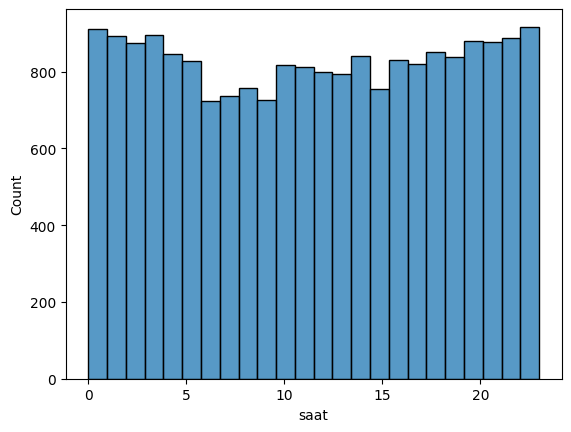

In [ ]:
# sns.boxplot(df["saat"])
sns.histplot(data = df, x = "saat")

### Lag Feature

In [ ]:
# random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [ ]:
df.sort_values(by = ["depremin_olus_zamani"],
               axis = 0,
               inplace = True)

In [ ]:
df.head()

,no,deprem_kodu,enlem,boylam,derinlik,xM,Tip,Yer,depremin_olus_zamani,ay,yıl,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,temizlenmis_yer,çeyreklik
19907,19908,19150214082000,38.80,42.50,30.0,5.7,Ke,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,2,1915,14,6,8,0,45,6,BITLIS,1
19906,19907,19150228124702,37.70,43.10,30.0,5.5,Ke,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,2,1915,28,6,12,0,59,8,SIRNAK,1
19905,19906,19150401054105,40.50,44.50,35.0,4.9,Ke,AZERBAYCAN,1915-04-01 05:41:05.000,4,1915,1,3,5,0,91,13,AZERBAYCAN,2
19904,19905,19150519044802,37.62,39.47,10.0,5.5,Ke,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,5,1915,19,2,4,1,139,20,SANLIURFA,2
19903,19904,19150923072001,40.00,43.00,15.0,4.4,Ke,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,9,1915,23,3,7,0,266,38,KARS,3


In [ ]:
# lag features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['deprem_lag_' + str(lag)] = dataframe.groupby(["temizlenmis_yer"])['xM'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [ ]:
df.head()

,no,deprem_kodu,enlem,boylam,derinlik,xM,Tip,Yer,depremin_olus_zamani,ay,yıl,ay_gun,hafta_gun,saat,aksam,yıl_gün,yıl_hafta,temizlenmis_yer,çeyreklik
19907,19908,19150214082000,38.80,42.50,30.0,5.7,Ke,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,2,1915,14,6,8,0,45,6,BITLIS,1
19906,19907,19150228124702,37.70,43.10,30.0,5.5,Ke,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,2,1915,28,6,12,0,59,8,SIRNAK,1
19905,19906,19150401054105,40.50,44.50,35.0,4.9,Ke,AZERBAYCAN,1915-04-01 05:41:05.000,4,1915,1,3,5,0,91,13,AZERBAYCAN,2
19904,19905,19150519044802,37.62,39.47,10.0,5.5,Ke,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,5,1915,19,2,4,1,139,20,SANLIURFA,2
19903,19904,19150923072001,40.00,43.00,15.0,4.4,Ke,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,9,1915,23,3,7,0,266,38,KARS,3


In [ ]:
# çeşitli shiftler/lagler/gecikmeler girelim. Gecikme  o zamanki değer demekti unutma. 3 ay ve katları olacak şekilde bakıyorum! Quarter aldım.
df = lag_features(df, [1, 2, 3, 6, 9, 12, 15, 18])

In [ ]:
df.isnull().sum()

no                         0
deprem_kodu                0
enlem                      0
boylam                     0
derinlik                   0
xM                         0
Tip                        0
Yer                        0
depremin_olus_zamani       0
ay                         0
yıl                        0
ay_gun                     0
hafta_gun                  0
saat                       0
aksam                      0
yıl_gün                    0
yıl_hafta                  0
temizlenmis_yer            0
çeyreklik                  0
deprem_lag_1             369
deprem_lag_2             604
deprem_lag_3             786
deprem_lag_6            1205
deprem_lag_9            1537
deprem_lag_12           1834
deprem_lag_15           2100
deprem_lag_18           2343
dtype: int64

In [ ]:
df.head()

,no,deprem_kodu,enlem,boylam,derinlik,xM,Tip,Yer,depremin_olus_zamani,ay,...,temizlenmis_yer,çeyreklik,deprem_lag_1,deprem_lag_2,deprem_lag_3,deprem_lag_6,deprem_lag_9,deprem_lag_12,deprem_lag_15,deprem_lag_18
19907,19908,19150214082000,38.80,42.50,30.0,5.7,Ke,CEMALETTIN-AHLAT (BITLIS) [South West 3.7 km],1915-02-14 08:20:00.600,2,...,BITLIS,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19906,19907,19150228124702,37.70,43.10,30.0,5.5,Ke,MEZRA-BEYTUSSEBAP (SIRNAK) [North West 9.0 km],1915-02-28 12:47:02.400,2,...,SIRNAK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19905,19906,19150401054105,40.50,44.50,35.0,4.9,Ke,AZERBAYCAN,1915-04-01 05:41:05.000,4,...,AZERBAYCAN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19904,19905,19150519044802,37.62,39.47,10.0,5.5,Ke,CATLI-SIVEREK (SANLIURFA) [South East 3.5 km],1915-05-19 04:48:02.400,5,...,SANLIURFA,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19903,19904,19150923072001,40.00,43.00,15.0,4.4,Ke,EVYAPAN-KAGIZMAN (KARS) [South West 5.8 km],1915-09-23 07:20:01.000,9,...,KARS,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Mean

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['deprem_roll_mean_' + str(window)] = dataframe.groupby(["temizlenmis_yer"])['xM']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [ ]:
df = roll_mean_features(df, [12, 18])

In [ ]:
df.isnull().sum()

no                         0
deprem_kodu                0
enlem                      0
boylam                     0
derinlik                   0
xM                         0
Tip                        0
Yer                        0
depremin_olus_zamani       0
ay                         0
yıl                        0
ay_gun                     0
hafta_gun                  0
saat                       0
aksam                      0
yıl_gün                    0
yıl_hafta                  0
temizlenmis_yer            0
çeyreklik                  0
deprem_lag_1             369
deprem_lag_2             604
deprem_lag_3             786
deprem_lag_6            1205
deprem_lag_9            1537
deprem_lag_12           1834
deprem_lag_15           2100
deprem_lag_18           2343
deprem_roll_mean_12     1640
deprem_roll_mean_18     1640
dtype: int64

### Exponentially Weighted Mean Features

In [ ]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['deprem_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["temizlenmis_yer"])['xM'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [3, 6, 9, 12]

In [ ]:
df = ewm_features(df, alphas, lags)

In [ ]:
df.isnull().sum()

no                                0
deprem_kodu                       0
enlem                             0
boylam                            0
derinlik                          0
xM                                0
Tip                               0
Yer                               0
depremin_olus_zamani              0
ay                                0
yıl                               0
ay_gun                            0
hafta_gun                         0
saat                              0
aksam                             0
yıl_gün                           0
yıl_hafta                         0
temizlenmis_yer                   0
çeyreklik                         0
deprem_lag_1                    369
deprem_lag_2                    604
deprem_lag_3                    786
deprem_lag_6                   1205
deprem_lag_9                   1537
deprem_lag_12                  1834
deprem_lag_15                  2100
deprem_lag_18                  2343
deprem_roll_mean_12         

### One Hot Encoder

In [ ]:
df = pd.get_dummies(df, columns=['temizlenmis_yer'])

In [ ]:
df.shape

(19907, 417)

### Log1p (Bağımlı değişkenin logaritması)

In [ ]:
df['xM'] = np.log1p(df["xM"].values)

### Model

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [ ]:
df["depremin_olus_zamani"].min(), df["depremin_olus_zamani"].max()

(Timestamp('1915-02-14 08:20:00.600000'),
 Timestamp('2023-04-30 13:01:27.690000'))

In [ ]:
# 2023 3 ayı validasyon, öncekilerde eğitim

# 2023'nin başına kadar (2022'nın sonuna kadar) train seti.
train = df.loc[(df["depremin_olus_zamani"] < "2023-01-01"), :]

# 2023'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["depremin_olus_zamani"] >= "2023-01-01") & (df["depremin_olus_zamani"] < "2023-04-01"), :]

In [ ]:
cols = [col for col in train.columns if col not in ['no', 'deprem_kodu', "Tip", "Yer","depremin_olus_zamani","xM"]]

In [ ]:
df.columns

Index(['no', 'deprem_kodu', 'enlem', 'boylam', 'derinlik', 'xM', 'Tip', 'Yer',
       'depremin_olus_zamani', 'ay',
       ...
       'temizlenmis_yer_YESILYURT-ALTINTAS KUTAHYA ', 'temizlenmis_yer_YOZGAT',
       'temizlenmis_yer_YUKARIDOLAYLAR-SIMAV KUTAHYA ',
       'temizlenmis_yer_YUKARIYONCAAGAC-HISARCIK KUTAHYA ',
       'temizlenmis_yer_YUMRUTAS-GEDIZ KUTAHYA ',
       'temizlenmis_yer_YUNUSLAR-GEDIZ KUTAHYA ',
       'temizlenmis_yer_YUYLUK-DUMLUPINAR KUTAHYA ',
       'temizlenmis_yer_ZAFERTEPECALKOY-ALTINTAS KUTAHYA ',
       'temizlenmis_yer_ZONGULDAK', 'temizlenmis_yer_iZMiR'],
      dtype='object', length=417)

In [ ]:
Y_train = train['xM']
X_train = train[cols]

Y_val = val['xM']
X_val = val[cols]

In [ ]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((18428,), (18428, 411), (1383,), (1383, 411))

In [ ]:
########################
# LightGBM ile Zaman Serisi Modeli, kg knkm
########################

In [ ]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}
# metric mae: l1, absolute loss, mean_absolute_error, regression_l1
# mse: l2, square loss, mean_squared_error, mse, regression_l2, regression
# rmse, root square loss, root_mean_squared_error, l2_root
# mape, MAPE loss, mean_absolute_percentage_error

# num_leaves: bir ağaçtaki maksimum yaprak sayısı
# learning_rate: shrinkage_rate, eta
# feature_fraction: rf'nin random subspace özelliği. her iterasyonda rastgele göz önünde bulundurulacak değişken sayısı.
# max_depth: maksimum derinlik
# num_boost_round: n_estimators, number of boosting iterations. En az 10000-15000 civarı yapmak lazım.

# early_stopping_rounds: validasyon setindeki metrik belirli bir early_stopping_rounds'da ilerlemiyorsa yani
# hata düşmüyorsa modellemeyi durdur.
# hem train süresini kısaltır hem de overfit'e engel olur.
# nthread: num_thread, nthread, nthreads, n_jobs;

In [ ]:
cols

['enlem',
 'boylam',
 'derinlik',
 'ay',
 'yıl',
 'ay_gun',
 'hafta_gun',
 'saat',
 'aksam',
 'yıl_gün',
 'yıl_hafta',
 'çeyreklik',
 'deprem_lag_1',
 'deprem_lag_2',
 'deprem_lag_3',
 'deprem_lag_6',
 'deprem_lag_9',
 'deprem_lag_12',
 'deprem_lag_15',
 'deprem_lag_18',
 'deprem_roll_mean_12',
 'deprem_roll_mean_18',
 'deprem_ewm_alpha_095_lag_3',
 'deprem_ewm_alpha_095_lag_6',
 'deprem_ewm_alpha_095_lag_9',
 'deprem_ewm_alpha_095_lag_12',
 'deprem_ewm_alpha_09_lag_3',
 'deprem_ewm_alpha_09_lag_6',
 'deprem_ewm_alpha_09_lag_9',
 'deprem_ewm_alpha_09_lag_12',
 'deprem_ewm_alpha_08_lag_3',
 'deprem_ewm_alpha_08_lag_6',
 'deprem_ewm_alpha_08_lag_9',
 'deprem_ewm_alpha_08_lag_12',
 'deprem_ewm_alpha_07_lag_3',
 'deprem_ewm_alpha_07_lag_6',
 'deprem_ewm_alpha_07_lag_9',
 'deprem_ewm_alpha_07_lag_12',
 'deprem_ewm_alpha_05_lag_3',
 'deprem_ewm_alpha_05_lag_6',
 'deprem_ewm_alpha_05_lag_9',
 'deprem_ewm_alpha_05_lag_12',
 'temizlenmis_yer_#NAME?',
 'temizlenmis_yer_ABAS-EMET KUTAHYA ',
 'tem

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  #early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  #verbose_eval=100
                  )

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


8.504564574252031

In [ ]:
########################
# Değişken Önem Düzeyleri
########################

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

                                               feature  split       gain
4                                                  yıl     34  78.671997
38                           deprem_ewm_alpha_05_lag_3      9   9.863426
2                                             derinlik     19   9.068760
39                           deprem_ewm_alpha_05_lag_6      5   1.322894
41                          deprem_ewm_alpha_05_lag_12      3   0.769741
0                                                enlem      1   0.184525
1                                               boylam      1   0.118657
272                              temizlenmis_yer_KONYA      0   0.000000
280               temizlenmis_yer_KURECI-EMET_KUTAHYA_      0   0.000000
279            temizlenmis_yer_KURDUMAN-SIMAV_KUTAHYA_      0   0.000000
278               temizlenmis_yer_KULCU-SIMAV_KUTAHYA_      0   0.000000
277          temizlenmis_yer_KUCUKKOY-DOMANIC_KUTAHYA_      0   0.000000
276             temizlenmis_yer_KOSELER-SIMAV_KUTAH

,feature,split,gain
4,yıl,34,78.671997
38,deprem_ewm_alpha_05_lag_3,9,9.863426
2,derinlik,19,9.068760
39,deprem_ewm_alpha_05_lag_6,5,1.322894
41,deprem_ewm_alpha_05_lag_12,3,0.769741
0,enlem,1,0.184525
1,boylam,1,0.118657
272,temizlenmis_yer_KONYA,0,0.000000
280,temizlenmis_yer_KURECI-EMET_KUTAHYA_,0,0.000000
279,temizlenmis_yer_KURDUMAN-SIMAV_KUTAHYA_,0,0.000000


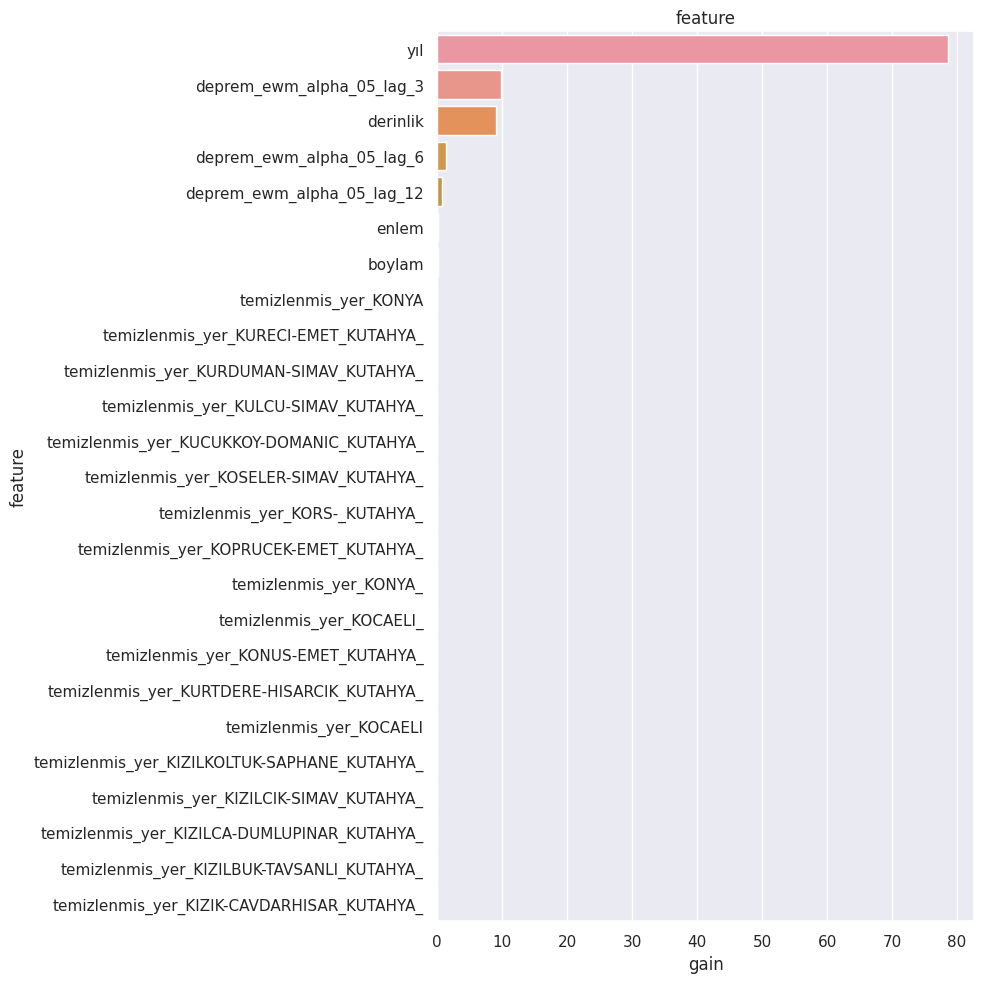

,feature,split,gain
4,yıl,34,78.671997
38,deprem_ewm_alpha_05_lag_3,9,9.863426
2,derinlik,19,9.068760
39,deprem_ewm_alpha_05_lag_6,5,1.322894
41,deprem_ewm_alpha_05_lag_12,3,0.769741
0,enlem,1,0.184525
1,boylam,1,0.118657
272,temizlenmis_yer_KONYA,0,0.000000
280,temizlenmis_yer_KURECI-EMET_KUTAHYA_,0,0.000000
279,temizlenmis_yer_KURDUMAN-SIMAV_KUTAHYA_,0,0.000000


In [ ]:
plot_lgb_importances(model, num=30, plot=True)

In [ ]:
########################
# Final Model
########################

train = df.loc[~df.xM.isna()]
Y_train = train['xM']
X_train = train[cols]


test = df.loc[~df.xM.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109966 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
test_preds

array([1.63116   , 1.63116   , 1.63116   , ..., 1.59840877, 1.59840877,
       1.59840877])

<Axes: ylabel='Count'>

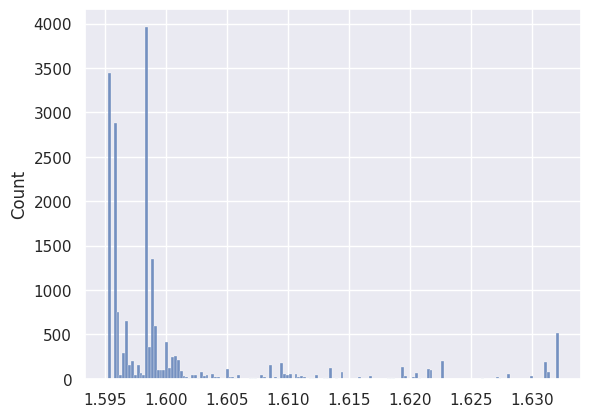

In [ ]:
sns.histplot(test_preds)

In [ ]:
X_test.shape

(19907, 411)

In [ ]:
cols

['enlem',
 'boylam',
 'derinlik',
 'ay',
 'yıl',
 'ay_gun',
 'hafta_gun',
 'saat',
 'aksam',
 'yıl_gün',
 'yıl_hafta',
 'çeyreklik',
 'deprem_lag_1',
 'deprem_lag_2',
 'deprem_lag_3',
 'deprem_lag_6',
 'deprem_lag_9',
 'deprem_lag_12',
 'deprem_lag_15',
 'deprem_lag_18',
 'deprem_roll_mean_12',
 'deprem_roll_mean_18',
 'deprem_ewm_alpha_095_lag_3',
 'deprem_ewm_alpha_095_lag_6',
 'deprem_ewm_alpha_095_lag_9',
 'deprem_ewm_alpha_095_lag_12',
 'deprem_ewm_alpha_09_lag_3',
 'deprem_ewm_alpha_09_lag_6',
 'deprem_ewm_alpha_09_lag_9',
 'deprem_ewm_alpha_09_lag_12',
 'deprem_ewm_alpha_08_lag_3',
 'deprem_ewm_alpha_08_lag_6',
 'deprem_ewm_alpha_08_lag_9',
 'deprem_ewm_alpha_08_lag_12',
 'deprem_ewm_alpha_07_lag_3',
 'deprem_ewm_alpha_07_lag_6',
 'deprem_ewm_alpha_07_lag_9',
 'deprem_ewm_alpha_07_lag_12',
 'deprem_ewm_alpha_05_lag_3',
 'deprem_ewm_alpha_05_lag_6',
 'deprem_ewm_alpha_05_lag_9',
 'deprem_ewm_alpha_05_lag_12',
 'temizlenmis_yer_#NAME?',
 'temizlenmis_yer_ABAS-EMET KUTAHYA ',
 'tem

In [ ]:
df["xM"].describe([0.90,0.95,0.99]).T

count    19907.000000
mean         1.600619
std          0.099430
min          1.504077
50%          1.568616
90%          1.740466
95%          1.808289
99%          1.902108
max          2.186051
Name: xM, dtype: float64

In [ ]:
df.loc[0,"xM"]

1.667706820558076

In [ ]:
np.expm1(2.186051)

7.899997537031302

In [ ]:
test_preds.max()

1.6321772098279232

In [ ]:
np.expm1(test_preds.max())

4.114999030320558

In [ ]:
df["temizlenmis_yer"].head()

KeyError: ignored

In [ ]:
df.columns